In [1]:
# Importing Libraries
import tensorflow as tf
import os
import numpy as np
import sys
import random
import cv2
import glob
import matplotlib.pyplot as plt
import xlrd
import tensorflow.keras.backend as K
import pandas as pd
import requests
# import nvidia_smi

from PIL import Image
from io import BytesIO
from tqdm.notebook import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
from tensorflow.python.client import device_lib
from tensorflow.keras.layers import *
from tensorflow.keras import Model


# Changing directories to access the dataset
d = os.getcwd()
if d != '/home/ec2-user/SageMaker/Semantic_Segmentation' :
    os.chdir("..")
from labels import *

In [2]:
labelID = {}
rgbColorID = {}

for i,label in enumerate(labels):
    labelID[i] = label.name
    rgbColorID[i] = label.color

print(labelID)
print(rgbColorID)

{0: 'unlabeled', 1: 'dynamic', 2: 'ground', 3: 'road', 4: 'sidewalk', 5: 'parking', 6: 'rail track', 7: 'building', 8: 'wall', 9: 'fence', 10: 'guard rail', 11: 'bridge', 12: 'tunnel', 13: 'pole', 14: 'traffic light', 15: 'traffic sign', 16: 'vegetation', 17: 'terrain', 18: 'sky', 19: 'person', 20: 'rider', 21: 'car', 22: 'truck', 23: 'bus', 24: 'caravan', 25: 'trailer', 26: 'train', 27: 'motorcycle', 28: 'bicycle'}
{0: (0, 0, 0), 1: (111, 74, 0), 2: (81, 0, 81), 3: (128, 64, 128), 4: (244, 35, 232), 5: (250, 170, 160), 6: (230, 150, 140), 7: (70, 70, 70), 8: (102, 102, 156), 9: (190, 153, 153), 10: (180, 165, 180), 11: (150, 100, 100), 12: (150, 120, 90), 13: (153, 153, 153), 14: (250, 170, 30), 15: (220, 220, 0), 16: (107, 142, 35), 17: (152, 251, 152), 18: (70, 130, 180), 19: (220, 20, 60), 20: (255, 0, 0), 21: (0, 0, 142), 22: (0, 0, 70), 23: (0, 60, 100), 24: (0, 0, 90), 25: (0, 0, 110), 26: (0, 80, 100), 27: (0, 0, 230), 28: (119, 11, 32)}


In [3]:
def rgb_to_onehot(rgb_image, colormap):
    '''Function to one hot encode RGB mask labels
        Inputs: 
            rgb_image - image matrix (eg. 256 x 256 x 3 dimension numpy ndarray)
            colormap - dictionary of color to label id
        Output: One hot encoded image of dimensions (height x width x num_classes) where num_classes = len(colormap)
    '''
    num_classes = len(colormap)
    shape = rgb_image.shape[:2]+(num_classes,)
    encoded_image = np.zeros( shape, dtype=np.int8 )
    index = 0
    for i, cls in enumerate(colormap):
        encoded_image[:,:,index] = np.all(rgb_image.reshape( (-1,3) ) == colormap[i], axis=1).reshape(shape[:2])
        index += 1
        
    return encoded_image

In [4]:
# Input Image Dimensions
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
numClasses = 29
batchSize = 16
learningRate = 0.001
numOfEpoch = 100

In [5]:
def My_Generator(image_filenames, labels, batch_size):
    idx = 0
    batch_x = image_filenames[idx * batch_size:(idx + 1) * batch_size]
    batch_y = labels[idx * batch_size:(idx + 1) * batch_size]

    X_train = []
    Y_train = []

    for i in tqdm(range(len(batch_x))):
        response = requests.get(batch_x[i])
        train = np.asarray(Image.open(BytesIO(response.content)))
        train = cv2.resize(train, (IMG_WIDTH,IMG_HEIGHT), interpolation = cv2.INTER_AREA)
        X_train.append(train)

    for i in tqdm(range(len(batch_y))):
        response = requests.get(batch_y[i])
        img1 = np.asarray(Image.open(BytesIO(response.content)).convert('RGB'))
#             imgCopy = np.zeros(img1.shape, dtype = 'uint8')
#             for i,cls in enumerate(rgbColorID):
#                 if i in otherClassIndices:
#                     imgCopy[np.all(img1.reshape((-1,3)) == rgbColorID[i],axis=1).reshape(img1.shape[:2])] = rgbColorID[0]
#                 else:
#                     imgCopy[np.all(img1.reshape((-1,3)) == rgbColorID[i],axis=1).reshape(img1.shape[:2])] = rgbColorID[i]
        Mask = cv2.resize(img1, (IMG_WIDTH,IMG_HEIGHT), interpolation = cv2.INTER_AREA)
#         Mask = rgb_to_onehot(Mask, rgbColorID)
        Y_train.append(Mask)

    np.savez_compressed('Val29', image = np.array(X_train, dtype='uint8'),
                                   label = np.array(Y_train, dtype='uint8'))
    
    return 100

In [6]:
parameter = False
if parameter:
    temp = My_Generator(validationImagesNames, validationMasksNames,len(validationImagesNames))

In [7]:
def ICNet(nClasses, input_height=224, input_width=224):
    inputs = Input(shape=(input_height, input_width, 3))

    # (1/2)
    y = Lambda(lambda x: tf.image.resize(x, size=(int(x.shape[1])//2, int(x.shape[2])//2), method='bilinear'), name='data_sub2')(inputs)
    y = Conv2D(32, 3, strides=2, padding='same', activation='relu', name='conv1_1_3x3_s2')(y)
    y = BatchNormalization(name='conv1_1_3x3_s2_bn')(y)
    y = Conv2D(32, 3, padding='same', activation='relu', name='conv1_2_3x3')(y)
    y = BatchNormalization(name='conv1_2_3x3_s2_bn')(y)
    y = Conv2D(64, 3, padding='same', activation='relu', name='conv1_3_3x3')(y)
    y = BatchNormalization(name='conv1_3_3x3_bn')(y)
    y_ = MaxPooling2D(pool_size=3, strides=2, name='pool1_3x3_s2')(y)
    
    y = Conv2D(128, 1, name='conv2_1_1x1_proj')(y_)
    y = BatchNormalization(name='conv2_1_1x1_proj_bn')(y)
    y_ = Conv2D(32, 1, activation='relu', name='conv2_1_1x1_reduce')(y_)
    y_ = BatchNormalization(name='conv2_1_1x1_reduce_bn')(y_)
    y_ = ZeroPadding2D(name='padding1')(y_)
    y_ = Conv2D(32, 3, activation='relu', name='conv2_1_3x3')(y_)
    y_ = BatchNormalization(name='conv2_1_3x3_bn')(y_)
    y_ = Conv2D(128, 1, name='conv2_1_1x1_increase')(y_)
    y_ = BatchNormalization(name='conv2_1_1x1_increase_bn')(y_)
    y = Add(name='conv2_1')([y,y_])
    y_ = Activation('relu', name='conv2_1/relu')(y)

    y = Conv2D(32, 1, activation='relu', name='conv2_2_1x1_reduce')(y_)
    y = BatchNormalization(name='conv2_2_1x1_reduce_bn')(y)
    y = ZeroPadding2D(name='padding2')(y)
    y = Conv2D(32, 3, activation='relu', name='conv2_2_3x3')(y)
    y = BatchNormalization(name='conv2_2_3x3_bn')(y)
    y = Conv2D(128, 1, name='conv2_2_1x1_increase')(y)
    y = BatchNormalization(name='conv2_2_1x1_increase_bn')(y)
    y = Add(name='conv2_2')([y,y_])
    y_ = Activation('relu', name='conv2_2/relu')(y)

    y = Conv2D(32, 1, activation='relu', name='conv2_3_1x1_reduce')(y_)
    y = BatchNormalization(name='conv2_3_1x1_reduce_bn')(y)
    y = ZeroPadding2D(name='padding3')(y)
    y = Conv2D(32, 3, activation='relu', name='conv2_3_3x3')(y)
    y = BatchNormalization(name='conv2_3_3x3_bn')(y)
    y = Conv2D(128, 1, name='conv2_3_1x1_increase')(y)
    y = BatchNormalization(name='conv2_3_1x1_increase_bn')(y)
    y = Add(name='conv2_3')([y,y_])
    y_ = Activation('relu', name='conv2_3/relu')(y)

    y = Conv2D(256, 1, strides=2, name='conv3_1_1x1_proj')(y_)
    y = BatchNormalization(name='conv3_1_1x1_proj_bn')(y)
    y_ = Conv2D(64, 1, strides=2, activation='relu', name='conv3_1_1x1_reduce')(y_)
    y_ = BatchNormalization(name='conv3_1_1x1_reduce_bn')(y_) 
    y_ = ZeroPadding2D(name='padding4')(y_)
    y_ = Conv2D(64, 3, activation='relu', name='conv3_1_3x3')(y_)
    y_ = BatchNormalization(name='conv3_1_3x3_bn')(y_)
    y_ = Conv2D(256, 1, name='conv3_1_1x1_increase')(y_)
    y_ = BatchNormalization(name='conv3_1_1x1_increase_bn')(y_)
    y = Add(name='conv3_1')([y,y_])
    z = Activation('relu', name='conv3_1/relu')(y)

    # (1/4)
    y_ = Lambda(lambda x: tf.image.resize(x, size=(int(x.shape[1])//2, int(x.shape[2])//2), method='bilinear'), name='conv3_1_sub4')(z)
    y = Conv2D(64, 1, activation='relu', name='conv3_2_1x1_reduce')(y_)
    y = BatchNormalization(name='conv3_2_1x1_reduce_bn')(y)
    y = ZeroPadding2D(name='padding5')(y)
    y = Conv2D(64, 3, activation='relu', name='conv3_2_3x3')(y)
    y = BatchNormalization(name='conv3_2_3x3_bn')(y)
    y = Conv2D(256, 1, name='conv3_2_1x1_increase')(y)
    y = BatchNormalization(name='conv3_2_1x1_increase_bn')(y)
    y = Add(name='conv3_2')([y,y_])
    y_ = Activation('relu', name='conv3_2/relu')(y)

    y = Conv2D(64, 1, activation='relu', name='conv3_3_1x1_reduce')(y_)
    y = BatchNormalization(name='conv3_3_1x1_reduce_bn')(y)
    y = ZeroPadding2D(name='padding6')(y)
    y = Conv2D(64, 3, activation='relu', name='conv3_3_3x3')(y)
    y = BatchNormalization(name='conv3_3_3x3_bn')(y)
    y = Conv2D(256, 1, name='conv3_3_1x1_increase')(y)
    y = BatchNormalization(name='conv3_3_1x1_increase_bn')(y)
    y = Add(name='conv3_3')([y,y_])
    y_ = Activation('relu', name='conv3_3/relu')(y)

    y = Conv2D(64, 1, activation='relu', name='conv3_4_1x1_reduce')(y_)
    y = BatchNormalization(name='conv3_4_1x1_reduce_bn')(y)
    y = ZeroPadding2D(name='padding7')(y)
    y = Conv2D(64, 3, activation='relu', name='conv3_4_3x3')(y)
    y = BatchNormalization(name='conv3_4_3x3_bn')(y)
    y = Conv2D(256, 1, name='conv3_4_1x1_increase')(y)
    y = BatchNormalization(name='conv3_4_1x1_increase_bn')(y)
    y = Add(name='conv3_4')([y,y_])
    y_ = Activation('relu', name='conv3_4/relu')(y)

    y = Conv2D(512, 1, name='conv4_1_1x1_proj')(y_)
    y = BatchNormalization(name='conv4_1_1x1_proj_bn')(y)
    y_ = Conv2D(128, 1, activation='relu', name='conv4_1_1x1_reduce')(y_)
    y_ = BatchNormalization(name='conv4_1_1x1_reduce_bn')(y_)
    y_ = ZeroPadding2D(padding=2, name='padding8')(y_)
    y_ = Conv2D(128, 3, dilation_rate=2, activation='relu', name='conv4_1_3x3')(y_)
    y_ = BatchNormalization(name='conv4_1_3x3_bn')(y_)
    y_ = Conv2D(512, 1, name='conv4_1_1x1_increase')(y_)
    y_ = BatchNormalization(name='conv4_1_1x1_increase_bn')(y_)
    y = Add(name='conv4_1')([y,y_])
    y_ = Activation('relu', name='conv4_1/relu')(y)

    y = Conv2D(128, 1, activation='relu', name='conv4_2_1x1_reduce')(y_)
    y = BatchNormalization(name='conv4_2_1x1_reduce_bn')(y)
    y = ZeroPadding2D(padding=2, name='padding9')(y)
    y = Conv2D(128, 3, dilation_rate=2, activation='relu', name='conv4_2_3x3')(y)
    y = BatchNormalization(name='conv4_2_3x3_bn')(y)
    y = Conv2D(512, 1, name='conv4_2_1x1_increase')(y)
    y = BatchNormalization(name='conv4_2_1x1_increase_bn')(y)
    y = Add(name='conv4_2')([y,y_])
    y_ = Activation('relu', name='conv4_2/relu')(y)

    y = Conv2D(128, 1, activation='relu', name='conv4_3_1x1_reduce')(y_)
    y = BatchNormalization(name='conv4_3_1x1_reduce_bn')(y)
    y = ZeroPadding2D(padding=2, name='padding10')(y)
    y = Conv2D(128, 3, dilation_rate=2, activation='relu', name='conv4_3_3x3')(y)
    y = BatchNormalization(name='conv4_3_3x3_bn')(y)
    y = Conv2D(512, 1, name='conv4_3_1x1_increase')(y)
    y = BatchNormalization(name='conv4_3_1x1_increase_bn')(y)
    y = Add(name='conv4_3')([y,y_])
    y_ = Activation('relu', name='conv4_3/relu')(y)

    y = Conv2D(128, 1, activation='relu', name='conv4_4_1x1_reduce')(y_)
    y = BatchNormalization(name='conv4_4_1x1_reduce_bn')(y)
    y = ZeroPadding2D(padding=2, name='padding11')(y)
    y = Conv2D(128, 3, dilation_rate=2, activation='relu', name='conv4_4_3x3')(y)
    y = BatchNormalization(name='conv4_4_3x3_bn')(y)
    y = Conv2D(512, 1, name='conv4_4_1x1_increase')(y)
    y = BatchNormalization(name='conv4_4_1x1_increase_bn')(y)
    y = Add(name='conv4_4')([y,y_])
    y_ = Activation('relu', name='conv4_4/relu')(y)

    y = Conv2D(128, 1, activation='relu', name='conv4_5_1x1_reduce')(y_)
    y = BatchNormalization(name='conv4_5_1x1_reduce_bn')(y)
    y = ZeroPadding2D(padding=2, name='padding12')(y)
    y = Conv2D(128, 3, dilation_rate=2, activation='relu', name='conv4_5_3x3')(y)
    y = BatchNormalization(name='conv4_5_3x3_bn')(y)
    y = Conv2D(512, 1, name='conv4_5_1x1_increase')(y)
    y = BatchNormalization(name='conv4_5_1x1_increase_bn')(y)
    y = Add(name='conv4_5')([y,y_])
    y_ = Activation('relu', name='conv4_5/relu')(y)

    y = Conv2D(128, 1, activation='relu', name='conv4_6_1x1_reduce')(y_)
    y = BatchNormalization(name='conv4_6_1x1_reduce_bn')(y)
    y = ZeroPadding2D(padding=2, name='padding13')(y)
    y = Conv2D(128, 3, dilation_rate=2, activation='relu', name='conv4_6_3x3')(y)
    y = BatchNormalization(name='conv4_6_3x3_bn')(y)
    y = Conv2D(512, 1, name='conv4_6_1x1_increase')(y)
    y = BatchNormalization(name='conv4_6_1x1_increase_bn')(y)
    y = Add(name='conv4_6')([y,y_])
    y = Activation('relu', name='conv4_6/relu')(y)

    y_ = Conv2D(1024, 1, name='conv5_1_1x1_proj')(y)
    y_ = BatchNormalization(name='conv5_1_1x1_proj_bn')(y_)
    y = Conv2D(256, 1, activation='relu', name='conv5_1_1x1_reduce')(y)
    y = BatchNormalization(name='conv5_1_1x1_reduce_bn')(y)
    y = ZeroPadding2D(padding=4, name='padding14')(y)
    y = Conv2D(256, 3, dilation_rate=4, activation='relu', name='conv5_1_3x3')(y)
    y = BatchNormalization(name='conv5_1_3x3_bn')(y)
    y = Conv2D(1024, 1, name='conv5_1_1x1_increase')(y)
    y = BatchNormalization(name='conv5_1_1x1_increase_bn')(y)
    y = Add(name='conv5_1')([y,y_])
    y_ = Activation('relu', name='conv5_1/relu')(y)

    y = Conv2D(256, 1, activation='relu', name='conv5_2_1x1_reduce')(y_)
    y = BatchNormalization(name='conv5_2_1x1_reduce_bn')(y)
    y = ZeroPadding2D(padding=4, name='padding15')(y)
    y = Conv2D(256, 3, dilation_rate=4, activation='relu', name='conv5_2_3x3')(y)
    y = BatchNormalization(name='conv5_2_3x3_bn')(y)
    y = Conv2D(1024, 1, name='conv5_2_1x1_increase')(y)
    y = BatchNormalization(name='conv5_2_1x1_increase_bn')(y)
    y = Add(name='conv5_2')([y,y_])
    y_ = Activation('relu', name='conv5_2/relu')(y)

    y = Conv2D(256, 1, activation='relu', name='conv5_3_1x1_reduce')(y_)
    y = BatchNormalization(name='conv5_3_1x1_reduce_bn')(y)
    y = ZeroPadding2D(padding=4, name='padding16')(y)
    y = Conv2D(256, 3, dilation_rate=4, activation='relu', name='conv5_3_3x3')(y)
    y = BatchNormalization(name='conv5_3_3x3_bn')(y)
    y = Conv2D(1024, 1, name='conv5_3_1x1_increase')(y)
    y = BatchNormalization(name='conv5_3_1x1_increase_bn')(y)
    y = Add(name='conv5_3')([y,y_])
    y = Activation('relu', name='conv5_3/relu')(y)

    h, w = y.shape[1:3].as_list()
    pool1 = AveragePooling2D(pool_size=(h,w), strides=(h,w), name='conv5_3_pool1')(y)
    pool1 = Lambda(lambda x: tf.image.resize(x, size=(h,w), method='bilinear'), name='conv5_3_pool1_interp')(pool1)
    pool2 = AveragePooling2D(pool_size=(h/2,w/2), strides=(h//2,w//2), name='conv5_3_pool2')(y)
    pool2 = Lambda(lambda x: tf.image.resize(x, size=(h,w), method='bilinear'), name='conv5_3_pool2_interp')(pool2)
    pool3 = AveragePooling2D(pool_size=(h/3,w/3), strides=(h//3,w//3), name='conv5_3_pool3')(y)
    pool3 = Lambda(lambda x: tf.image.resize(x, size=(h,w), method='bilinear'), name='conv5_3_pool3_interp')(pool3)
    pool6 = AveragePooling2D(pool_size=(h/4,w/4), strides=(h//4,w//4), name='conv5_3_pool6')(y)
    pool6 = Lambda(lambda x: tf.image.resize(x, size=(h,w), method='bilinear'), name='conv5_3_pool6_interp')(pool6)

    y = Add(name='conv5_3_sum')([y, pool1, pool2, pool3, pool6])
    y = Conv2D(256, 1, activation='relu', name='conv5_4_k1')(y)
    y = BatchNormalization(name='conv5_4_k1_bn')(y)
    aux_1 = Lambda(lambda x: tf.image.resize(x, size=(int(x.shape[1])*2, int(x.shape[2])*2), method='bilinear'), name='conv5_4_interp')(y)
    y = ZeroPadding2D(padding=2, name='padding17')(aux_1)
    y = Conv2D(128, 3, dilation_rate=2, name='conv_sub4')(y)
    y = BatchNormalization(name='conv_sub4_bn')(y)
    y_ = Conv2D(128, 1, name='conv3_1_sub2_proj')(z)
    y_ = BatchNormalization(name='conv3_1_sub2_proj_bn')(y_)
    y = Add(name='sub24_sum')([y,y_])
    y = Activation('relu', name='sub24_sum/relu')(y)

    aux_2 = Lambda(lambda x: tf.image.resize(x, size=(int(x.shape[1])*2, int(x.shape[2])*2), method='bilinear'), name='sub24_sum_interp')(y)
    y = ZeroPadding2D(padding=2, name='padding18')(aux_2)
    y_ = Conv2D(128, 3, dilation_rate=2, name='conv_sub2')(y)
    y_ = BatchNormalization(name='conv_sub2_bn')(y_)

    # (1)
    y = Conv2D(32, 3, strides=2, padding='same', activation='relu', name='conv1_sub1')(inputs)
    y = BatchNormalization(name='conv1_sub1_bn')(y)
    y = Conv2D(32, 3, strides=2, padding='same', activation='relu', name='conv2_sub1')(y)
    y = BatchNormalization(name='conv2_sub1_bn')(y)
    y = Conv2D(64, 3, strides=2, padding='same', activation='relu', name='conv3_sub1')(y)
    y = BatchNormalization(name='conv3_sub1_bn')(y)
    y = Conv2D(128, 1, name='conv3_sub1_proj')(y)
    y = BatchNormalization(name='conv3_sub1_proj_bn')(y)

    y = Add(name='sub12_sum')([y,y_])
    y = Activation('relu', name='sub12_sum/relu')(y)
    y = Lambda(lambda x: tf.image.resize(x, size=(int(x.shape[1])*8, int(x.shape[2])*8), method='bilinear'), name='sub12_sum_interp')(y)
    
    o = Conv2D(nClasses, 1, name='conv6_cls')(y)

    
    o_shape = Model(inputs, o).output_shape

    outputHeight = o_shape[1]
    outputWidth = o_shape[2]

    o = (Reshape((outputHeight,outputWidth, nClasses)))(o)
    o = (Activation('sigmoid'))(o)
    model = Model(inputs, o)
    model.outputWidth = outputWidth
    model.outputHeight = outputHeight

    return model

In [8]:
model = ICNet(numClasses, IMG_WIDTH, IMG_HEIGHT)
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=learningRate), loss='categorical_crossentropy', metrics=[tf.keras.metrics.MeanIoU(num_classes=numClasses),
                                                                                                                         tf.keras.metrics.Precision(),
                                                                                                                         tf.keras.metrics.Recall(),
                                                                                                                         'accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
data_sub2 (Lambda)              (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_1_3x3_s2 (Conv2D)         (None, 64, 64, 32)   896         data_sub2[0][0]                  
__________________________________________________________________________________________________
conv1_1_3x3_s2_bn (BatchNormali (None, 64, 64, 32)   128         conv1_1_3x3_s2[0][0]             
____________________________________________________________________________________________

In [9]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_multiclass.h5',
                                                  verbose=2,
                                                  save_best_only=True,
                                                  monitor='loss',
                                                  mode='min')

callbacks = [
             tf.keras.callbacks.EarlyStopping(patience=1,
                                              monitor='loss',
                                              mode='min'),
             tf.keras.callbacks.TensorBoard(log_dir='logs',
                                            write_graph=True)]

In [10]:
response = requests.get('https://test-seg.s3.amazonaws.com/Cityscrapes/Train29.npz')
train = np.load(BytesIO(response.content))

In [11]:
results = model.fit(train['image'], train['label'], validation_split=0.3, batch_size = batchSize,callbacks=callbacks, verbose = 1,epochs = numOfEpoch)

Train on 2082 samples, validate on 893 samples
Epoch 1/100
2082/2082 [==============================] - 110s 53ms/sample - loss: 1.2902 - mean_io_u: 0.4839 - precision: 0.2578 - recall: 0.8428 - accuracy: 0.6112 - val_loss: 1.3345 - val_mean_io_u: 0.4838 - val_precision: 0.4985 - val_recall: 0.6722 - val_accuracy: 0.5484
Epoch 2/100
2082/2082 [==============================] - 93s 45ms/sample - loss: 0.7138 - mean_io_u: 0.4839 - precision: 0.7678 - recall: 0.7263 - accuracy: 0.7286 - val_loss: 1.0037 - val_mean_io_u: 0.4838 - val_precision: 0.6807 - val_recall: 0.6358 - val_accuracy: 0.6425
Epoch 3/100
2082/2082 [==============================] - 93s 44ms/sample - loss: 0.6573 - mean_io_u: 0.4839 - precision: 0.8352 - recall: 0.6762 - accuracy: 0.7448 - val_loss: 0.7275 - val_mean_io_u: 0.4838 - val_precision: 0.8224 - val_recall: 0.6251 - val_accuracy: 0.7283
Epoch 4/100
2082/2082 [==============================] - 93s 45ms/sample - loss: 0.6190 - mean_io_u: 0.4839 - precision: 0.8671

In [12]:
train = []

In [13]:
model.save('models/ICnet-S256-C29-B16')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: models/ICnet-S256-C29-B16/assets


In [14]:
response = requests.get('https://test-seg.s3.amazonaws.com/Cityscrapes/Val29.npz')
test = np.load(BytesIO(response.content))
X_test = test['image']
Y_test = test['label']

In [15]:
model = tf.keras.models.load_model('models/ICnet-S256-C29-B16')

In [16]:
preds_val = model.predict(X_test, verbose=1)

500/500 [==============================] - 12s 24ms/sample


In [17]:
def onehot_to_rgb(onehot, colormap):
    '''Function to decode encoded mask labels
        Inputs: 
            onehot - one hot encoded image matrix (height x width x num_classes)
            colormap - dictionary of color to label id
        Output: Decoded RGB image (height x width x 3) 
    '''
    single_layer = np.argmax(onehot, axis=-1)
    output = np.zeros( onehot.shape[:2]+(3,) )
    for k in colormap.keys():
        output[single_layer==k] = colormap[k]
    return np.uint8(output)

In [18]:
preds_valRGB = []
for i in range(len(X_test)):
    preds_valRGB.append(onehot_to_rgb(preds_val[i], rgbColorID))

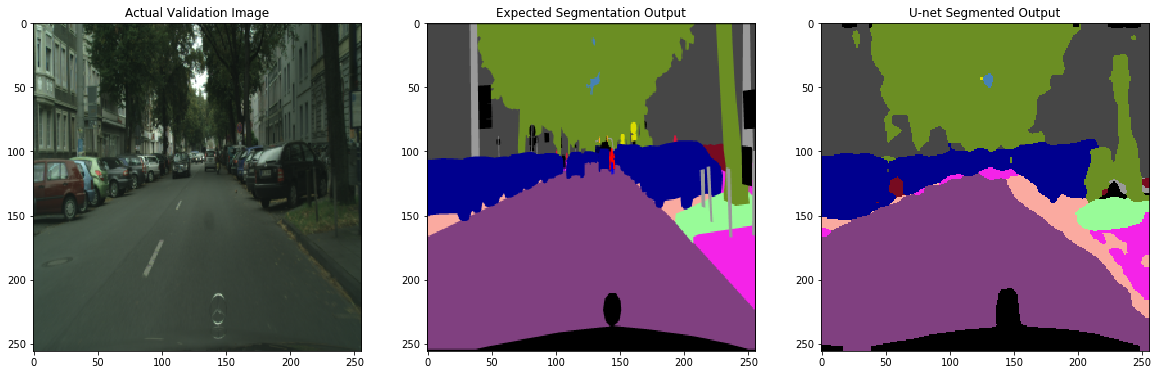

In [22]:
# Comparing the results

ix = random.randint(0, len(preds_valRGB))
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(1,3,1)
ax1.imshow(X_test[ix])
ax1.title.set_text('Actual Validation Image')
ax1.grid(False)
ax2 = fig.add_subplot(1,3,2)
ax2.set_title('Expected Segmentation Output')
ax2.imshow(Y_test[ix])
ax2.grid(False)
ax3 = fig.add_subplot(1,3,3)
ax3.set_title('U-net Segmented Output')
ax3.imshow(preds_valRGB[ix])
ax3.grid(False)

In [23]:
iou = []
classesPresent = ['Absent']*numClasses
s = np.zeros(numClasses)
p = np.zeros(numClasses)
for j in tqdm(range(len(X_test))):
    temp = rgb_to_onehot(Y_test[j], rgbColorID)
    for i in range(numClasses):
        if np.any(temp[:,:,i]) == 1:
            classesPresent[i] = 'Present'
            p[i] += 1
        intersection = np.logical_and(temp[:,:,i], preds_val[j][:,:,i])
        union = np.logical_or(temp[:,:,i], preds_val[j][:,:,i])
        s[i] += np.sum(intersection) / np.sum(union)
        


for i in range(numClasses):
    if p[i] == 0:
        iou.append(str(0)+"%")
    else:
        iou.append(str(round((s[i]*100)/p[i], 3)) + '%')

labels = []
for i in range(numClasses):
    labels.append(labelID[i])
    
classes = {'labels': labels,
        'IOU Accuracy': iou,
        'Classes Encountered' : classesPresent
        }

df = pd.DataFrame(classes, columns = ['labels','IOU Accuracy', 'Classes Encountered'])

print (df)


           labels IOU Accuracy Classes Encountered
0       unlabeled       8.681%             Present
1         dynamic       0.687%             Present
2          ground       4.698%             Present
3            road      33.421%             Present
4        sidewalk       4.623%             Present
5         parking       1.648%             Present
6      rail track       2.038%             Present
7        building       18.21%             Present
8            wall       1.454%             Present
9           fence       1.723%             Present
10     guard rail       1.646%             Present
11         bridge       0.894%             Present
12         tunnel           0%              Absent
13           pole       0.618%             Present
14  traffic light       0.234%             Present
15   traffic sign       0.483%             Present
16     vegetation      14.468%             Present
17        terrain       1.378%             Present
18            sky       3.067%

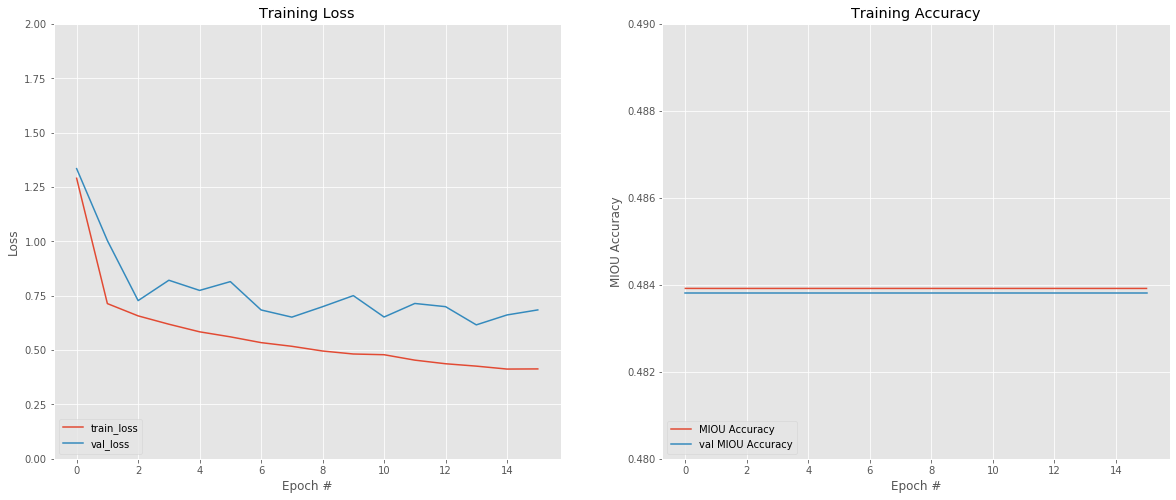

In [26]:
N = len(results.history['loss'])

#Plot the model evaluation history
plt.style.use("ggplot")
fig = plt.figure(figsize=(20,8))

fig.add_subplot(1,2,1)
plt.title("Training Loss")
plt.plot(np.arange(0, N), results.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), results.history["val_loss"], label="val_loss")
plt.ylim(0, 2)

plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")

fig.add_subplot(1,2,2)
plt.title("Training Accuracy")
plt.plot(np.arange(0, N), results.history["mean_io_u"], label="MIOU Accuracy")
plt.plot(np.arange(0, N), results.history["val_mean_io_u"], label="val MIOU Accuracy")
plt.ylim(0.48, 0.49)

plt.xlabel("Epoch #")
plt.ylabel("MIOU Accuracy")
plt.legend(loc="lower left")
plt.show()

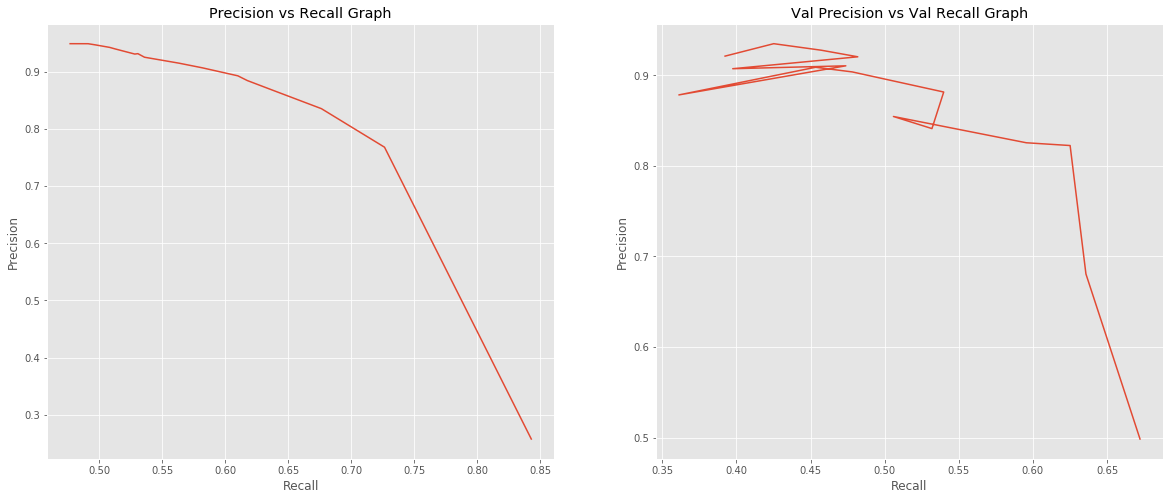

In [27]:
plt.style.use("ggplot")
fig = plt.figure(figsize=(20,8))

fig.add_subplot(1,2,1)
plt.plot(results.history['recall'], results.history['precision']) 
# naming the x axis 
plt.xlabel('Recall') 
# naming the y axis 
plt.ylabel('Precision') 
  
# giving a title to my graph 
plt.title('Precision vs Recall Graph') 
  
    
fig.add_subplot(1,2,2)
plt.plot(results.history['val_recall'], results.history['val_precision']) 
# naming the x axis 
plt.xlabel('Recall') 
# naming the y axis 
plt.ylabel('Precision') 
  
# giving a title to my graph 
plt.title('Val Precision vs Val Recall Graph') 
    
# function to show the plot 
plt.show() 